In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('../../data/processed/airport_june_2019.csv')
# df.drop("To Date", axis=1, inplace=True)
df.head()

,From Date,PM2.5,PM10,NO,NO2,SO2,CO,Ozone,RH,WS,WD,AT,HOUR,MONTH
0,2019-06-01 00:00:00,17.086000,58.661489,59.723048,16.579524,12.179626,0.373962,13.710286,87.716774,1.227097,184.529677,27.810215,0,6
1,2019-06-01 01:00:00,16.093861,51.717188,59.477379,15.399406,11.966923,0.349231,13.906923,87.869348,1.153152,187.873913,27.744130,1,6
2,2019-06-01 02:00:00,15.659320,54.967634,56.430673,14.609010,12.471415,0.305619,13.750286,88.223226,1.124731,181.798710,27.602903,2,6
3,2019-06-01 03:00:00,15.780962,53.554946,56.006408,13.140686,12.776481,0.294231,14.580286,88.747065,1.141848,176.929457,27.411304,3,6
4,2019-06-01 04:00:00,14.980377,53.374362,58.782404,13.335400,13.154128,0.298302,14.143962,88.678602,1.128280,173.737204,27.353011,4,6


In [3]:
# Convert the date column to a datetime object
df['From Date'] = pd.to_datetime(df['From Date'])

In [6]:
# Group the data by day and calculate the mean pollutant value
df = df.groupby(df['From Date'].dt.date).mean()

In [8]:
# Reset the index to make the date a column
daily_data = df.reset_index()

# Print the daily data
print(df)

                PM2.5        PM10         NO        NO2        SO2        CO  \
From Date                                                                      
2019-06-01  15.991063   57.592960  52.080472  17.474274  12.154786  0.329422   
2019-06-02  15.991063   57.592960  52.080472  17.474274  12.154786  0.329422   
2019-06-03  15.991063   57.592960  52.080472  17.474274  12.154786  0.329422   
2019-06-04  15.353910   58.621232  47.849692  16.181885   9.886935  0.332388   
2019-06-05  15.991063   57.592960  52.080472  17.474274  12.154786  0.329422   
...               ...         ...        ...        ...        ...       ...   
2023-03-30  27.435833  121.311774  81.698750  18.855000   8.529583  1.186250   
2023-03-31  22.987083  116.883441  78.961250  17.514583   8.596667  1.124583   
2023-04-01  29.550417  126.368394  76.149167  20.442500   8.667083  1.267083   
2023-04-02  24.175417  106.830061  75.831250  19.165000   8.551250  1.266667   
2023-04-03  22.066957   94.822238  70.41

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['CO'].values.reshape(-1, 1))

In [5]:
train_size = int(len(data) * 0.9)
train_data, test_data = data[:train_size,:], data[train_size:,:]

In [6]:
# Create the training and testing datasets
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [7]:
time_steps = 5
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)

In [9]:
history = model.fit(X_train, y_train, epochs=2, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/2
474/474 [==============================] - 31s 66ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 2/2
474/474 [==============================] - 30s 63ms/step - loss: 0.0012 - val_loss: 0.0020


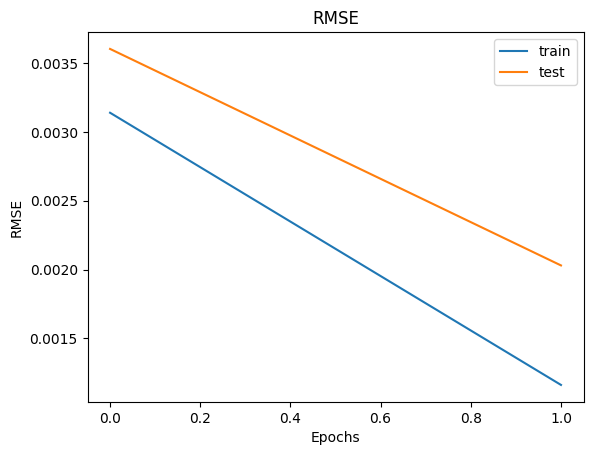

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [11]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])


106/106 [==============================] - 3s 25ms/step


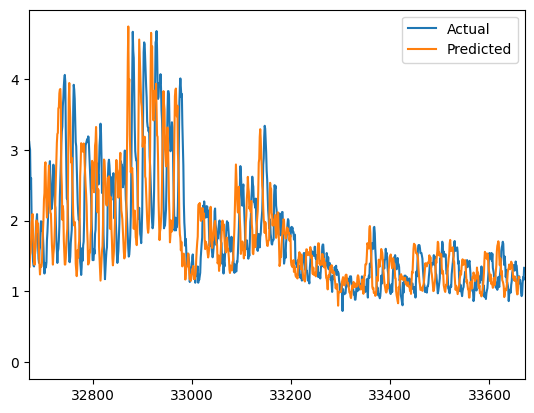

In [14]:
import matplotlib.pyplot as plt
plt.plot(df['CO'].values, label='Actual')
plt.plot(np.concatenate([train_predictions, test_predictions]), label='Predicted')
plt.xlim([len(df['CO'].values)-1000, len(df['CO'].values)])
plt.legend()
plt.show()

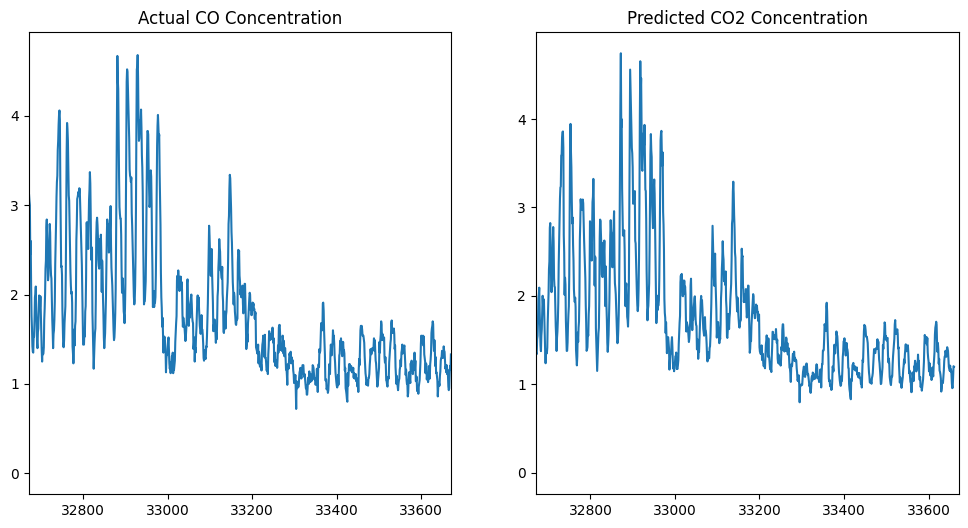

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(df['CO'].values)
ax1.set_title('Actual CO Concentration')
# show last 1000 points
ax1.set_xlim([len(df['CO'].values)-1000, len(df['CO'].values)])
ax2.plot(np.concatenate([train_predictions, test_predictions]))
# show last 1000 points
ax2.set_xlim([len(df['CO'].values)-1000, len(df['CO'].values)])
ax2.set_title('Predicted CO2 Concentration')

plt.show()
